In [1]:
import pandas as pd
import numpy as np

# Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

from sklearn import cross_validation

/Users/huoteng/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read data CSV
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
# 已知条件：女性的获救比例更高，1等舱乘客的获救比例更高，儿童的获救比例更高，在Cherbourg登船的乘客获救比例更高（有可能与乘客客舱有关）


# Delete unnecessary columns: Ticket and Cabin 
unnecessary_columns = ['Ticket', 'Cabin']
train_df = train_df.drop(unnecessary_columns, axis=1)
test_df = test_df.drop(unnecessary_columns, axis=1)

combine_df = [train_df, test_df]

# 对乘客姓名中的Title进行处理
# Title format: Mr. or Miss., use regex to extract title
for df in combine_df:
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [4]:
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [5]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [6]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine_df = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [7]:
for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


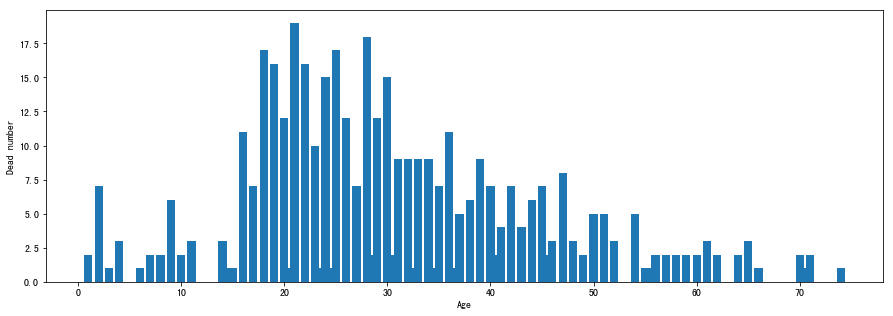

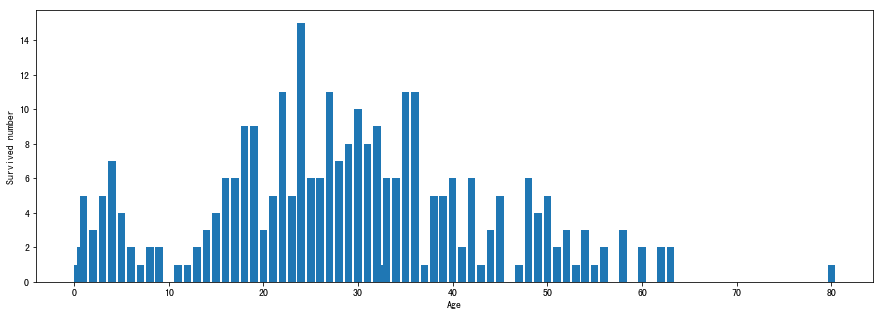

In [8]:
# TODO: 查看未填充缺失值之前Age的分布
survived_count = train_df.groupby(['Survived', 'Age'])['Age'].count()

plt.figure(figsize=(15, 5))
plt.bar(survived_count[0].index, survived_count[0])
plt.xlabel('Age')
plt.ylabel('Dead number')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(survived_count[1].index, survived_count[1])
plt.xlabel('Age')
plt.ylabel('Survived number')
plt.show()

In [9]:
# TODO1.1: 对Age的缺失值进行填充
# TODO1.2: 查看Age的生存比例分布，将Age设置阈值划分级别

def train_set_missing_ages_model(df):
    age_df = df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]

    known_age = age_df[age_df.Age.notnull()].values
    y = known_age[:, 0]
    X = known_age[:, 1:]
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
 
    set_age_regressor = SVR(C=1.0, epsilon=0.2)
#     set_age_regressor.fit(X_train, y_train)
#     pred = set_age_regressor.predict(X_test)
#     print(mean_absolute_error(y_test, pred))
    set_age_regressor.fit(X, y)
    
    return set_age_regressor


def set_missing_ages(df, regressor):
    age_df = df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]

    unknown_age = age_df[age_df.Age.isnull()].values
    pred = regressor.predict(unknown_age[:, 1:])
    df.loc[(df.Age.isnull()), 'Age'] = pred


In [10]:
# regressor = train_set_missing_ages_model(train_df)
# set_missing_ages(train_df, regressor)
# train_df.describe()


guess_ages = np.zeros((2,3))
for dataset in combine_df:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.072952,0.523008,0.381594,32.204208,1.728395
std,0.486592,0.836071,0.477990,13.326339,1.102743,0.806057,49.693429,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,0.000000,26.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,5.000000


In [11]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [12]:
for dataset in combine_df:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

train_df = train_df.drop(['AgeBand'], axis=1)
combine_df = [train_df, test_df]
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [13]:
# TODO2.1: 根据Parch和SibSp属性创建新的属性FamilySize
# TODO2.2: 查看不同FamilySize上的生存概率
# TODO2.2: 根据FailySize生成属性IsAlone

for dataset in combine_df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1
# train_df.groupby(['Survived', 'FamilySize'])['FamilySize'].count()



# TODO4: 将Embarked属性转为Int

# TODO5.1: 查看Fare属性上的生存概率
# TODO5.2: 根据生存概率设置阈值，对Fare属性进行等级划分

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [14]:

for dataset in combine_df:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()


,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [15]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine_df = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [16]:
for dataset in combine_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

combine_df = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,S,1,0
1,1,1,1,2,3,C,3,0
2,1,3,1,1,1,S,2,1
3,1,1,1,2,3,S,3,0
4,0,3,0,2,1,S,1,1
5,0,3,0,1,1,Q,1,1
6,0,1,0,3,3,S,1,1
7,0,3,0,0,2,S,4,0
8,1,3,1,1,1,S,3,0
9,1,2,1,0,2,C,3,0


In [17]:
# Embarked热独编码

# def dummy_features(df):
#     dummies_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
# #     dummies_sex = pd.get_dummies(df['Sex'], prefix='Sex')
# #     dummies_pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')

#     df = pd.concat([df, dummies_embarked], axis=1)
#     df.drop(['Embarked'], axis=1, inplace=True)
# #     df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1, inplace=True)
#     return df

# train_df = dummy_features(train_df)
# test_df = dummy_features(test_df)
# train_df.head()

freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,0,1,0
1,1,1,1,2,3,1,3,0
2,1,3,1,1,1,0,2,1
3,1,1,1,2,3,0,3,0
4,0,3,0,2,1,0,1,1


In [18]:






# # TODO1: 需要换一种方式填充Age的空值
# def train_set_missing_ages_model(df):
#     age_df = df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]

#     known_age = age_df[age_df.Age.notnull()].values
#     y = known_age[:, 0]
#     X = known_age[:, 1:]
    
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
 
#     set_age_regressor = SVR(C=1.0, epsilon=0.2)
# #     set_age_regressor.fit(X_train, y_train)
# #     pred = set_age_regressor.predict(X_test)
# #     print(mean_absolute_error(y_test, pred))
#     set_age_regressor.fit(X, y)
    
#     return set_age_regressor


# def set_missing_ages(df, regressor):
#     age_df = df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]

#     unknown_age = age_df[age_df.Age.isnull()].values
#     pred = regressor.predict(unknown_age[:, 1:])
#     df.loc[(df.Age.isnull()), 'Age'] = pred


# def set_cabin_type(df):
#     df.loc[df.Cabin.notnull(), 'Cabin'] = 'YES'
#     df.loc[df.Cabin.isnull(), 'Cabin'] = 'NO'


# def fit_age_fare_scaler(df):
#     scaler = StandardScaler()
#     scaler.fit(df[['Age', 'Fare']])
#     return scaler


# def scale_features(df, scaler):
#     scaled_values = scaler.transform(df[['Age', 'Fare']])
#     df['Age_scaled'] = scaled_values[:, 0]
#     df['Fare_scaled'] = scaled_values[:, 1]
#     return scaler


# def dummy_features(df):
#     dummies_cabin = pd.get_dummies(df['Cabin'], prefix='Cabin')
#     dummies_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
#     dummies_sex = pd.get_dummies(df['Sex'], prefix='Sex')
#     dummies_pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')

#     df = pd.concat([df, dummies_cabin, dummies_embarked, dummies_sex, dummies_pclass], axis=1)
#     df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1, inplace=True)
#     return df

    
# print('done')

In [19]:
# all_data = pd.read_csv('./input/train.csv')

# set_age_regressor = train_set_missing_ages_model(all_data)
# set_missing_ages(all_data, set_age_regressor)
# set_cabin_type(all_data)

# scaler = fit_age_fare_scaler(all_data)
# scale_features(all_data, scaler)

# all_data = dummy_features(all_data)

# all_data.head()
# # print('done')


# for dataset in combine_df:
#     dataset['Age*Class'] = dataset.Age * dataset.Pclass

# train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

for i in range(0, 5):
    train_df = train_df.append(train_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 890
Data columns (total 8 columns):
Survived    28512 non-null int64
Pclass      28512 non-null int64
Sex         28512 non-null int64
Age         28512 non-null int64
Fare        28512 non-null int64
Embarked    28512 non-null int64
Title       28512 non-null int64
IsAlone     28512 non-null int64
dtypes: int64(8)
memory usage: 2.0 MB


In [20]:
# train_np = train_df.values

# X = train_np[:, 1:]
# y = train_np[:, 0]

# clf = RandomForestClassifier(max_depth=6, random_state=42)

# # cross_validation.cross_val_score(clf, X, y, cv=5)

# clf.fit(X, y)
# test_np = test_df.values
# X_test = test_np[:, 1:]
# pred = clf.predict(X_test)
# result = pd.DataFrame({'PassengerId': test_df.PassengerId.values, 'Survived': pred.astype(np.int32)})
# result.to_csv('./submission.csv', index=False)
# print('done')


# Random Forest
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

random_forest = RandomForestClassifier(n_estimators=100)
cross_validation.cross_val_score(random_forest, X_train, Y_train, cv=5).mean()


# random_forest.fit(X_train, Y_train)
# Y_pred = random_forest.predict(X_test)
# random_forest.score(X_train, Y_train)

# print(random_forest.score(X_train, Y_train))
# result = pd.DataFrame({'PassengerId': test_df.PassengerId.values, 'Survived': Y_pred.astype(np.int32)})
# result.to_csv('./submission.csv', index=False)
# print('done')

0.8671086287677954

In [21]:

# submission_data = pd.read_csv('./input/test.csv')
# set_missing_ages(submission_data, set_age_regressor)
# set_cabin_type(submission_data)

# scale_features(submission_data, scaler)

# submission_data = dummy_features(submission_data)

# submission_df = submission_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# submission_features = submission_df.values

# pred = clf.predict(submission_features)
# result = pd.DataFrame({'PassengerId': submission_data.PassengerId.values, 'Survived': pred.astype(np.int32)})
# result.to_csv('./submission.csv', index=False)
# print('done')